In [ ]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding,
                                    TimeDistributed, Dense, RepeatVector,
                                    Activation, Flatten, Reshape, concatenate,
                                    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [ ]:
!unzip -qq '/content/drive/MyDrive/ds_study/data/dl/image_kor/data/Training/labeling/TL_라벨링 데이터_image(단일)_dog.zip' -d './train'
!unzip -qq '/content/drive/MyDrive/ds_study/data/dl/image_kor/data/Validation/labeling/VL_라벨링 데이터_image(단일)_dog.zip' -d './validation'

In [ ]:
!unzip -qq '/content/drive/MyDrive/ds_study/data/dl/image_kor/data/Training/ori/TS_image(단일)_dog.zip' -d './tr_image'
!unzip -qq '/content/drive/MyDrive/ds_study/data/dl/image_kor/data/Validation/ori/VS_image(단일)_dog.zip' -d './val_image'

In [ ]:
# 데이터 확인

from glob import glob

json_tr = glob('train/*.json')
print(len(json_tr))

json_val = glob('validation/*.json')
print(len(json_val))

4595
577


In [ ]:
import json

file = json.load(open(json_tr[0]))
print(file.keys())

#df_tr = pd.read_json(json_tr[0])
#df_val = pd.read_json(json_val[0])

#df_tr.to_csv('train.csv', encoding='utf-8')
#df_val.to_csv('validation.csv', encoding='utf-8')

dict_keys(['info', 'categories', 'images', 'annotations'])


In [ ]:
import pandas as pd

df_tr = pd.DataFrame()
df_tr['id'] = None
df_tr['caption'] = None

### train

In [ ]:
id = []
for i in range(len(json_tr)):
  file = json.load(open(json_tr[i]))

  # 이미지 별 id
  id_each = file['images'][0]['id']
  id.append(id_each)

caption = []
for i in range(len(json_tr)):
  file = json.load(open(json_tr[i]))
  tmp = []

  for j in range(len(file['annotations'])):   # 이미지 별 캡션
    c = file['annotations'][j]['korean']
    tmp.append(c)
  caption.append(tmp)

In [ ]:
df_tr['id'] = id
df_tr['caption'] = caption

### val

In [ ]:
import pandas as pd

df_val = pd.DataFrame()
df_val['id'] = None
df_val['caption'] = None

id = []
for i in range(len(json_val)):
  file = json.load(open(json_val[i]))
  id_each = file['images'][0]['id']
  id.append(id_each)

caption = []
for i in range(len(json_val)):
  file = json.load(open(json_val[i]))
  tmp = []

  for j in range(len(file['annotations'])):   # 이미지 별 캡션
    c = file['annotations'][j]['korean']
    tmp.append(c)
  caption.append(tmp)

df_val['id'] = id
df_val['caption'] = caption

In [ ]:
#df_val.to_csv('df_val.csv')

## 한국어 캡션 토큰화

In [ ]:
# %pip install konlpy

In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
from tqdm import tqdm

In [ ]:
# 토큰화 - 형태소

%%time
sent_token = []
for caption_list in tqdm(df_tr['caption']):
  tokens = [okt.morphs(sentence) for sentence in caption_list]
  sent_token.append(tokens)

100%|██████████| 4595/4595 [03:23<00:00, 22.62it/s]

CPU times: user 3min 22s, sys: 1.55 s, total: 3min 23s
Wall time: 3min 23s


### 한국어 임베딩 사전 만들기
- GloVe

In [ ]:
# !pip install glove-python3

In [ ]:
from glove import Corpus, Glove
import numpy as np

In [ ]:
sent_token_sep = []
for sublist in sent_token:
  for item in sublist:
    sent_token_sep.append(item)

In [ ]:
# corpus 생성
corpus = Corpus()
corpus.fit(sent_token_sep, window=20)

# model
glove = Glove(no_components=200, learning_rate = 0.01)
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)

# save
glove.save('/content' + '/glove_w20_epoch50.model')

# load glove
glove_model = Glove.load('/content' + '/glove_w20_epoch50.model')

In [ ]:
# word dict 생성
import pickle

word_dict = {}
for word in glove_model.dictionary.keys():
  word_dict[word] = glove_model.word_vectors[glove_model.dictionary[word]]
print('[Success !] Length of word dict... : ', len(word_dict))

# save word_dict
with open('/content' + '/glove_word_dict_128.pickle', 'wb') as f:
  pickle.dump(word_dict, f)
print('[Success !] Save word dict!...')

[Success !] Length of word dict... :  385
[Success !] Save word dict!...


In [ ]:
# 200차원 임베딩 딕셔너리
# 임베딩 저장 - numpy
embeddings_index = {}

for word in glove_model.dictionary.keys():
    embeddings = word_dict[word]
    coefs = np.asarray(embeddings, dtype='float32')
    embeddings_index[word] = coefs

## 캡션 전처리

캡션 중 최대 길이를 갖는 캡션의 길이를 찾고, 토큰화 된 문장을 하나의 리스트에 넣어 lookup이라는 딕셔너리에 추가. 각 이미지에 있는 id가 딕셔너리의 key값

In [ ]:
# '.' 삭제
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

In [ ]:
max_length = 0
for i in tqdm(range(4595)):
  tmp = json.load(open(json_tr[i]))
  id = tmp['images'][0]['file_name']
  descs = []
  for i in range(len(tmp['annotations'])):
    new_desc = okt.morphs(tmp['annotations'][i]['korean'])
    max_length = max(max_length, len(new_desc))
    new_desc = ' '.join(new_desc)
    descs.append(f'startseq {new_desc} endseq')
  lookup[id] = descs
# lex = set(word)

100%|██████████| 4595/4595 [03:20<00:00, 22.96it/s]


In [ ]:
all_train_captions = []
for key, val in lookup.items():
  for cap in val:
    all_train_captions.append(cap)
len(all_train_captions)

115664

In [ ]:
# 빈도수
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts]
# print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

In [ ]:
# 각 단어에 인덱스 부여하는 딕셔너리

idxtoword = {} # {인덱스 : 단어}
wordtoidx = {} # {단어 : 인덱스}

ix = 1
for w in vocab:
  wordtoidx[w] = ix
  idxtoword[ix] = w
  ix += 1

vocab_size = len(idxtoword) + 1
max_length += 2 # start token, stop token 때문에 +2
print(max_length)

19


## 데이터 생성

In [ ]:
# 데이터 생성 함수
# 이미지 설명(descriptions), 이미지(photos),
# 단어를 인덱스로 매핑한 딕셔너리(wordtoidx), 최대 문장 길이(max_length),
# 각 배치에서 사용할 이미지 수(num_photos_per_batch)

def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):

  # 이미지(x1), 입력 시퀀스(x2), 출력 시퀀스(y)
  x1, x2, y = [], [], []
  n = 0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key]
      for desc in desc_list:

        # 각 단어를 시퀀스 리스트 형태로 변환
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]

        # 시퀀스 조합(1개단어, 2개단어 ...) 별로 저장
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
        if n==num_photos_per_batch:
          yield ([np.array(x1), np.array(x2)], np.array(y))
          x1, x2, y = [], [], []
          n = 0

## 이미지 인코딩 및 inceptionV3 모델 학습

In [ ]:
# 이미지 특징 추출

USE_INCEPTION = True

if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')

  # InceptionV3의 마지막 layer(softmax) 이전 layer까지 가져와서 특징 추출
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299  # InceptionV3가 요구하는 이미지 크기
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input

else:
  encode_model = MobileNet(weights='imagenet', include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input


96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
# 이미지 인코딩 함수

def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS) # 크기 조정
  x = tensorflow.keras.preprocessing.image.img_to_array(img) # PIL 이미지 -> numpy 배열
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x)
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [ ]:
# 이미지 파일명

train_img = []
val_img = []

# train
for i in range(4595):
  tmp = json.load(open(json_tr[i]))
  file_name = tmp['images'][0]['file_name']

  train_img.append(file_name)

In [ ]:
# val
for i in range(len(json_val)):
  tmp = json.load(open(json_val[i]))
  file_name = tmp['images'][0]['file_name']

  val_img.append(file_name)

In [ ]:
# 디렉토리 생성
directory = '/content/tr_image/koreandata_fin/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# feature 추출
root_captioning = "/content/tr_image"

train_path = os.path.join(root_captioning, "koreandata_fin", f'train{OUTPUT_DIM}.pkl')

if not os.path.exists(train_path):
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning, id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))

    # 딕셔너리를 pickle 파일에 저장
    encoding_train[id] = encodeImage(img)
    print('id')
  with open(train_path, 'wb') as fp:
    pickle.dump(encoding_train, fp)
else:
  # pickle 파일이 이미 존재하면 불러오기
  with open(train_path, 'rb') as fp:
    encoding_train = pickle.load(fp)

In [ ]:
# 디렉터리 생성
directory = '/content/val_image/koreandata_fin/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
%%time
root_captioning = "/content/val_image"

val_path = os.path.join(root_captioning, "koreandata_fin", f'val{OUTPUT_DIM}.pkl')
if not os.path.exists(val_path):
  encoding_val = {}
  for id in tqdm(val_img):
    image_path = os.path.join(root_captioning, id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_val[id] = encodeImage(img)
  with open(val_path, 'wb') as fp:
    pickle.dump(encoding_val, fp)
else:
  with open(val_path, 'rb') as fp:
    encoding_val = pickle.load(fp)

## 캡션 생성 모델 학습 및 테스트

In [ ]:
# Neural Network 생성

# Glove로부터 embedding matrix 구축 -> weight matrix로 사용
embedding_dim = 200  # 임베딩차원 = 200 (=> features)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# 프리파라미터값 조정

inputs1 = Input(shape=(OUTPUT_DIM, ))  # 이미지 특징 벡터 입력
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))  # 시퀀스 데이터(캡션) 입력
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])  # 이미지 특징 벡터와 LSTM의 출력 결합
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 19)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 19, 200)              77600     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### train

In [ ]:
number_pics_per_bath = 3
steps = len(lookup)//number_pics_per_bath

In [ ]:
# 34분 걸림
EPOCHS = 10
model_path = os.path.join(root_captioning, 'koreandata_fin', f'caption-model.hdf5')
if not os.path.exists(model_path):

  # 첫 번째 훈련 - 높은 학습률
  for i in tqdm(range(EPOCHS*2)):
    generator = data_generator(lookup, encoding_train,
                               wordtoidx, max_length, number_pics_per_bath)

    caption_model.fit_generator(generator, epochs=1,
                                steps_per_epoch=steps, verbose=1)

    caption_model.optimizer.lr = 1e-4
    number_pics_per_bath = 6
    steps = len(lookup)//number_pics_per_bath

  # 두 번째 훈련
  for i in range(EPOCHS):
    generator = data_generator(lookup, encoding_train,
                               wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1,
                                steps_per_epoch=steps, verbose=1)
  caption_model.save_weights(model_path)
else:
  caption_model.load_weights(model_path)

## Eval

In [ ]:
START = 'startseq'
STOP = 'endseq'

def generateCaption(photo):
  in_text = START
  for i in range(max_length):
    # 현재까지의 텍스트를 단어 인덱스의 시퀀스로 변환하고 패딩
    sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
    sequence = pad_sequences([sequence], maxlen=max_length)

    # 모델을 사용하여 다음 단어의 확률 분포를 예측
    yhat = caption_model.predict([photo, sequence], verbose=0)
    yhat = np.argmax(yhat) # 가장 높은 확률을 가지는 단어의 인덱스를 선택
    word = idxtoword[yhat] # 인덱스를 단어로 변환
    in_text += ' ' + word # 생성된 단어를 현재까지의 텍스트에 추가
    if word == STOP:
      break

  # 시작과 종료 토큰을 제외하고 생성된 텍스트를 추출
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

/content/val_image/IMG_0150573_dog(dog).jpg


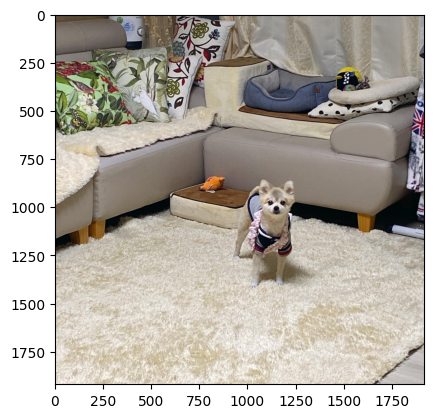

Caption:  인형 은 주로 아이 들 이 가지 고 노 는 장난감 입니다 .
/content/val_image/IMG_0221356_dog(dog).jpg


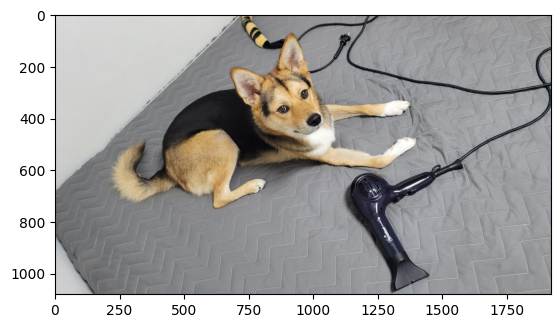

Caption:  개는 사진 의 왼쪽 중간 에 있습니다 .
/content/val_image/IMG_0094158_dog(dog).jpg


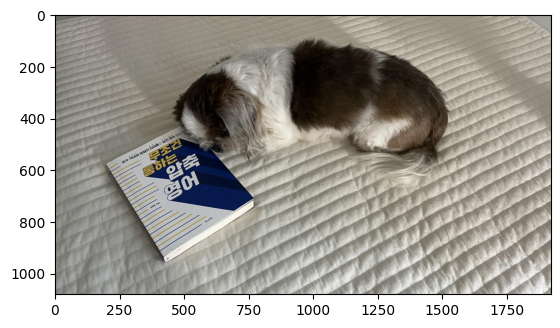

Caption:  개 1 은 개 들 중 에서 사진 의 가장 왼쪽 에 있습니다 .
/content/val_image/IMG_0153347_dog(dog).jpg


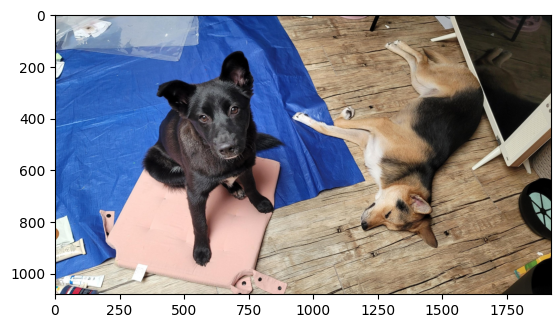

Caption:  개 가 사진 에 찍혀 있습니다 .
/content/val_image/IMG_0228545_dog(dog).jpg


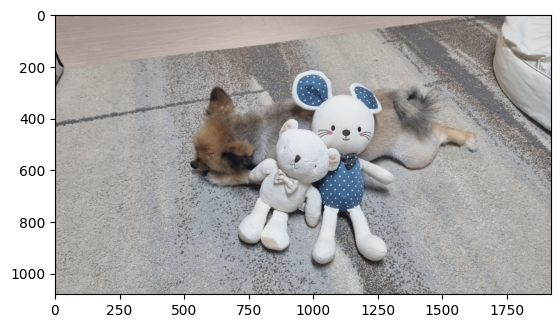

Caption:  개는 사진 의 오른쪽 중간 에 있습니다 .
/content/val_image/IMG_0224054_dog(dog).jpg


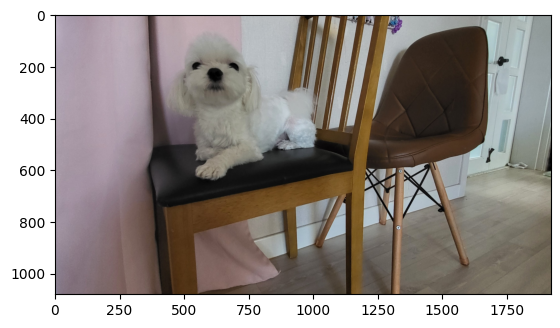

Caption:  사람 은 이 사진 의 주제가 아닙니다 .
/content/val_image/IMG_0204181_dog(dog).jpg


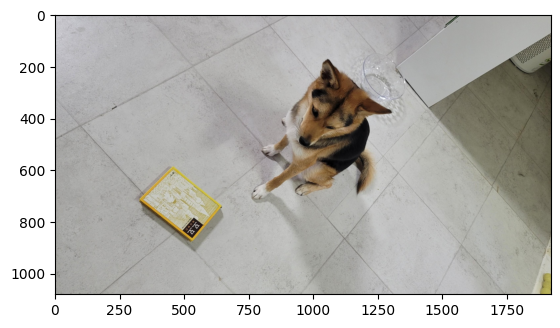

Caption:  개 가 사진 에 찍혀 있습니다 .
/content/val_image/IMG_0230672_dog(dog).jpg


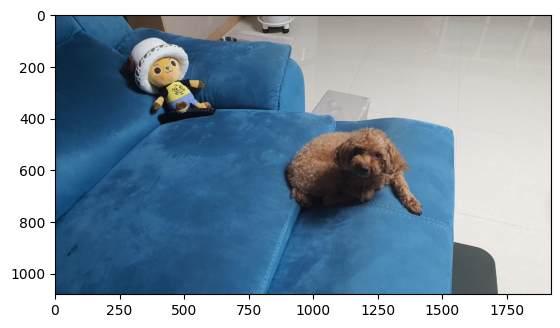

Caption:  개는 사진 의 오른쪽 중간 에 있습니다 .
/content/val_image/IMG_0035256_dog(dog).jpg


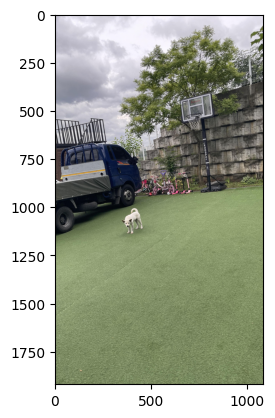

Caption:  개 가 사진 에 찍혀 있습니다 .
/content/val_image/IMG_0220484_dog(dog).jpg


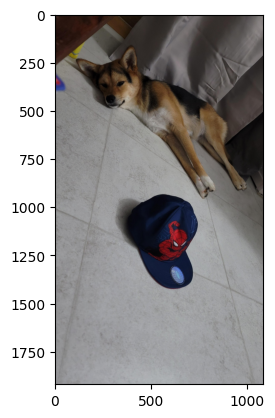

Caption:  개는 사진 의 오른쪽 중간 에 있습니다 .


In [ ]:
# test data 캡셔닝 확인
import random

for i in range(10):
  z = random.randint(0,300)
  pic = list(encoding_val.keys())[z]
  image = encoding_val[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning, pic))
  x = plt.imread(os.path.join(root_captioning, pic))
  plt.imshow(x)
  plt.show()
  print('Caption: ', generateCaption(image))